# Morgan Fingerprints with CATBoost for Viscosity Predictions 

Morgan fingerprints dataset shape: (5695, 2048)
Final dataset shape: (5695, 8)
Learning rate set to 0.052028
0:	learn: 0.6862817	total: 4.13ms	remaining: 4.12s
100:	learn: 0.3728128	total: 317ms	remaining: 2.83s
200:	learn: 0.3134623	total: 630ms	remaining: 2.5s
300:	learn: 0.2787196	total: 930ms	remaining: 2.16s
400:	learn: 0.2550959	total: 1.23s	remaining: 1.84s
500:	learn: 0.2375943	total: 1.53s	remaining: 1.52s
600:	learn: 0.2242423	total: 1.82s	remaining: 1.21s
700:	learn: 0.2130861	total: 2.13s	remaining: 907ms
800:	learn: 0.2042323	total: 2.44s	remaining: 606ms
900:	learn: 0.1969959	total: 2.87s	remaining: 315ms
999:	learn: 0.1916073	total: 3.31s	remaining: 0us
Test MAE: 0.1591241668837346
Test RMSE: 0.221581159121424
Test R2: 0.8934751975552988


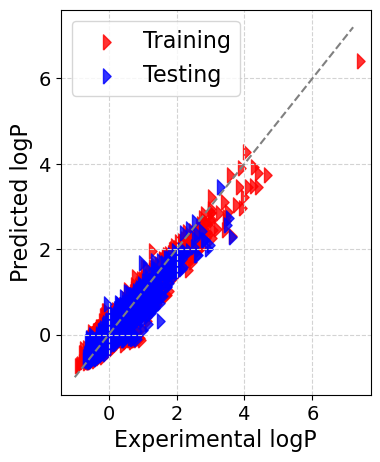

In [ ]:
import math
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import seaborn as sns
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
from mol2vec.helpers import depict_identifier, plot_2D_vectors, IdentifierTable, mol_to_svg
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from gensim.models import word2vec
from sklearn import preprocessing
from catboost import CatBoostRegressor

# Loading organic solvents viscosity data
input_dir = 'D:/Postdoc-Work/Manuacripts/NLP-Organic_Solvents-Properties/Comm Chemistry/Revisions_R1/Data_ML-pred/Mol2vec/Viscosity/'
dataset = pd.read_csv(input_dir + 'Oragnic-Solvents_Viscosity_All.csv', encoding='unicode_escape')

mol_smiles = dataset['CANON_SMILES']
log_visc = dataset['log_visc']
temperature = dataset['Temperature (K)']

# Calculate Morgan fingerprints using RDKit
def morgan_fingerprints(smiles, radius=2, n_bits=2048):
    mols = [Chem.MolFromSmiles(i) for i in smiles]
    fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits) for mol in mols]
    fingerprints_array = [list(fp) for fp in fingerprints]
    return pd.DataFrame(fingerprints_array)
fingerprints_df = morgan_fingerprints(dataset['CANON_SMILES'])

# Merge fingerprints into the dataset
input_features = pd.concat([fingerprints_df, temperature], axis=1)
print("Dataset shape:", dataset.shape)

# Simple train-test split
X_train, X_test, y_train, y_test, smiles_train, smiles_test = train_test_split(
    input_features, log_visc, mol_smiles, test_size=0.2, random_state=365)

# Train CatBoost
cat_model = CatBoostRegressor(verbose=100)
cat_model.fit(X_train, y_train)

# Predict on train
y_pred_train = cat_model.predict(X_train)
train_df = pd.DataFrame({
    'SMILES': smiles_train.reset_index(drop=True),
    'viscosity_actual': y_train.reset_index(drop=True),
    'viscosity_vap_pred': y_pred_train
})
train_df.to_csv('CATBoost_MorganFP-Training_Viscosity_365Seed.csv', index=False)

# Predict on test
y_pred_test = cat_model.predict(X_test)
test_df = pd.DataFrame({
    'SMILES': smiles_test.reset_index(drop=True),
    'viscosity_actual': y_test.reset_index(drop=True),
    'viscosity_pred': y_pred_test
})
test_df.to_csv('CATBoost_MorganFP-Testing_Viscosity_365Seed.csv', index=False)

# Print metrics
print("Test MAE:", mean_absolute_error(y_test, y_pred_test))
print("Test RMSE:", math.sqrt(mean_squared_error(y_test, y_pred_test)))
print("Test R2:", r2_score(y_test, y_pred_test))

# Scatterplot
plt.figure(figsize=(4, 5))
ln = np.arange(min(min(y_train), min(y_test)), max(max(y_train), max(y_test)), 0.2)
plt.plot(ln, ln, 'gray', linestyle='--')

plt.scatter(y_train, y_pred_train, color='red', label='Training', alpha=0.8,
            marker=MarkerStyle("D", fillstyle="right"), s=60)
plt.scatter(y_test, y_pred_test, color='blue', label='Testing', alpha=0.8,
            marker=MarkerStyle("D", fillstyle="right"), s=60)

plt.xlabel('Experimental logP', fontsize=16)
plt.ylabel('Predicted logP', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(color='#D3D3D3', linestyle='--', which='both', axis='both')
plt.legend(loc='upper left', fontsize=16)
plt.show()